# Training: Quantum case

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 130
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../data/restaurant_v2_train.txt')
val_labels, val_data = read_data('../data/restaurant_v2_dev.txt')
test_labels, test_data = read_data('../data/restaurant_v2_test.txt')

In [4]:
train_data[:5]

['I love the restaurant',
 'I dislike the restaurant',
 'I loved the great food',
 'I loved the nice food',
 'I loved the tasty food']

In [5]:
train_labels[:5]

[[1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]

### Creating and parameterising diagrams

In [6]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Filter and simplify diagrams

In [7]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Let's see the form of the diagram for a relative clause on the subject of a sentence:

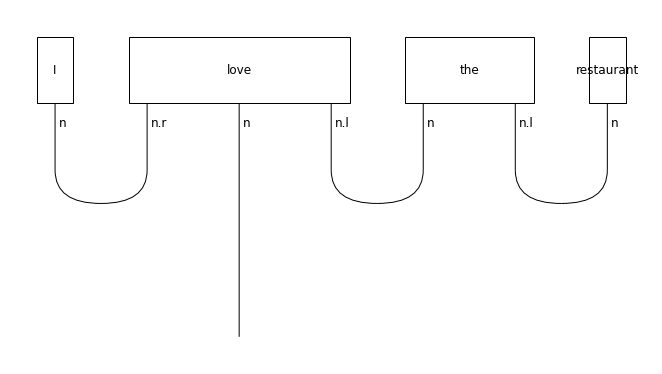

In [8]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In object-based relative clauses the noun that follows the relative pronoun is the object of the sentence:

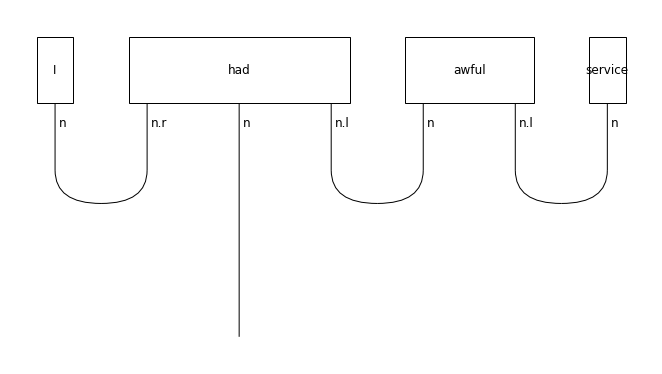

In [9]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

### Create circuits

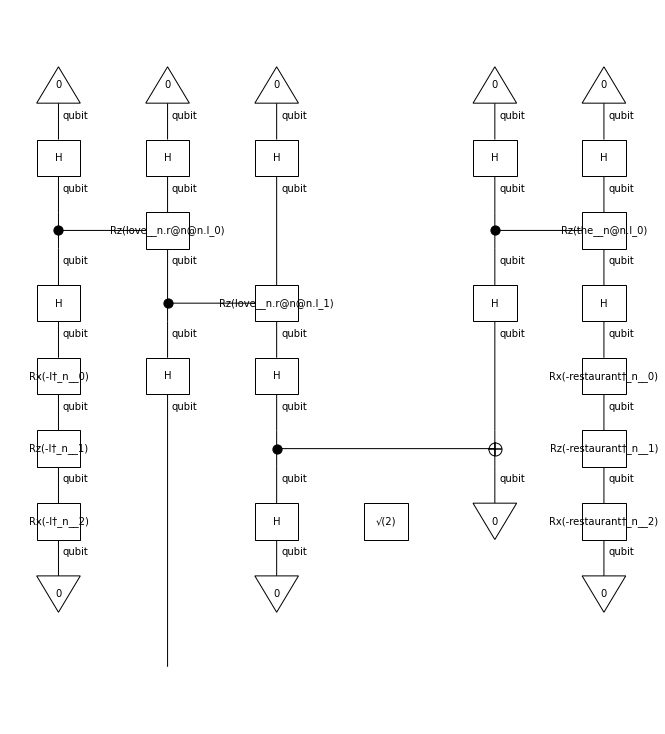

In [31]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Training

### Create Noisy Model

In [32]:
import qiskit_aer.noise as noise

# Define qubits
qubits = range(32)

# Define noise model
noise_model = noise.NoiseModel()
max_prob_re = 0.1
max_prob_dep = 0.001

def random_probability(max_val):
    """Generate a single random probability that does not exceed max_val"""
    return np.random.uniform(0, max_val)

# Create random depolarizing error probabilities
dep_prob = random_probability(max_prob_dep)
dep_err = noise.depolarizing_error(dep_prob, 1)

# Create random readout error probabilities
readout_prob = random_probability(max_prob_re)
ro_err = noise.ReadoutError([
    [1 - readout_prob, readout_prob],
    [readout_prob, 1 - readout_prob],
])

# Add depolarizing error to single-qubit gates on each qubit
for i in qubits:
    noise_model.add_quantum_error(dep_err, ["h", "s"], [i])

# Add readout error for each qubit
for i in qubits:
    noise_model.add_readout_error(ro_err, qubits=[i])

In [33]:
print(f"Depolarizing Error Probability: {dep_prob}")
print(f"Readout Error Probability: {readout_prob}")

Depolarizing Error Probability: 0.000524592620754848
Readout Error Probability: 0.04420153177948702


### Instantiate the model

In [70]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits + test_circuits

backend = AerBackend(noise_model=noise_model, simulation_method="extended_stabilizer")

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192,
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

AttributeError: 'pytket._tket.circuit.Command' object has no attribute 'name'

### Define loss and evaluation metric

In [66]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

### Initialise trainer

In [67]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

### Create datasets

In [68]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [69]:
trainer.fit(train_dataset, val_dataset, minimize_criterion=False)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-226 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-226 contains invalid parameters  for "stabilizer" method. [Experiment 1] Circuit circuit-227 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-227 contains invalid parameters  for "stabilizer" method. [Experiment 2] Circuit circuit-228 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-228 contains invalid parameters  for "stabilizer" method. [Experiment 3] Circuit circuit-229 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-229 contains invalid parameters  for "stabilizer" method. [Experiment 4] Circuit circuit-230 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-230 contains invalid parameters  for "stabilizer" method. [Experiment 5] Circuit circuit-231 contain

RuntimeError: ERROR: Circuit circuit-226 contains invalid instructions {"gates": {u}} for "stabilizer" method.Circuit circuit-226 contains invalid parameters  for "stabilizer" method.

## Results

Finally, we visualise the results and evaluate the model on the test data.

Validation accuracy: 0.43333333333333335


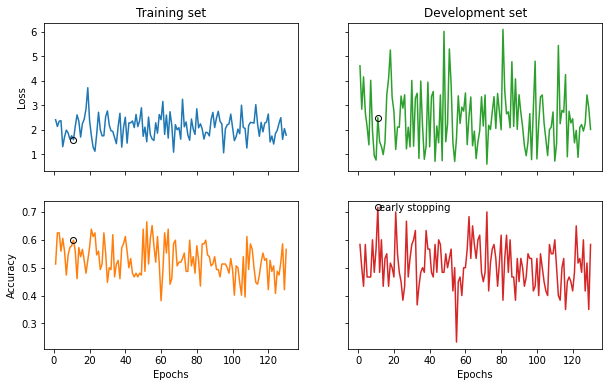

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.4, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
val_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', val_acc.item())

In [ ]:
test_acc = acc(model(test_circuits), test_labels)

# Calculate the loss
predictions = model(test_circuits)
loss = bce(predictions, np.array(test_labels))

print('Test accuracy:', test_acc.item())
print('Test loss:', loss.item())

Test accuracy: 0.45
Test loss: 2.054339003759501


In [ ]:
np.array(test_labels)

array([[0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1]])

In [ ]:
predictions

array([[0.72254335, 0.27745665],
       [0.13043478, 0.86956522],
       [0.26666667, 0.73333333],
       [0.48275862, 0.51724138],
       [0.25      , 0.75      ],
       [0.11111111, 0.88888889],
       [0.81481481, 0.18518519],
       [0.33333333, 0.66666667],
       [0.15151515, 0.84848485],
       [0.53846154, 0.46153846],
       [0.55882353, 0.44117647],
       [0.18      , 0.82      ],
       [0.45283019, 0.54716981],
       [0.43678161, 0.56321839],
       [0.41304348, 0.58695652],
       [1.        , 0.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 0.        ],
       [0.57142857, 0.42857143],
       [0.6       , 0.4       ],
       [1.        , 0.        ],
       [0.52941176, 0.47058824],
       [0.5       , 0.5       ],
       [0.51351351, 0.48648649],
       [0.42391304, 0.57608696]])

In [ ]:
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the filename with timestamp
filename = f"prediction_{timestamp}.txt"

# Save the array to the text file
np.savetxt(filename, predictions, fmt='%.8f', delimiter='\t', header='1\t0', comments='')

print(f"Array saved to {filename}")

Array saved to prediction_20240819_001426.txt


In [ ]:
import pandas as pd

# Convert the array to a DataFrame
df = pd.DataFrame(np.array(predictions), columns=["1", "0"])

# Save the DataFrame to an Excel file
df.to_excel("output1.xlsx", index=False, engine='openpyxl')

In [ ]:
import pandas as pd

# Convert the array to a DataFrame
df = pd.DataFrame(np.round(predictions), columns=["1", "0"])

# Save the DataFrame to an Excel file
df.to_excel("output2.xlsx", index=False, engine='openpyxl')